In [1]:
!nvidia-smi

Fri Oct  3 16:59:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        On  |   00000000:38:00.0 Off |                  N/A |
| 80%   76C    P1            541W /  575W |   28044MiB /  32607MiB |     96%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch
import clip
import ImageReward as RM
import matplotlib.pyplot as plt
import PIL
data = torch.load('./results/img_net_64_class_idxs_417_local_exploration_False_T_64_num_pt_iterations_200_switch_t_idx_31_guidance_1.3_guidance_target_1.3_samples.pt')

class_idxs = 417

In [2]:
data['final'].shape

torch.Size([1, 200, 3, 64, 64])

### Plot Images

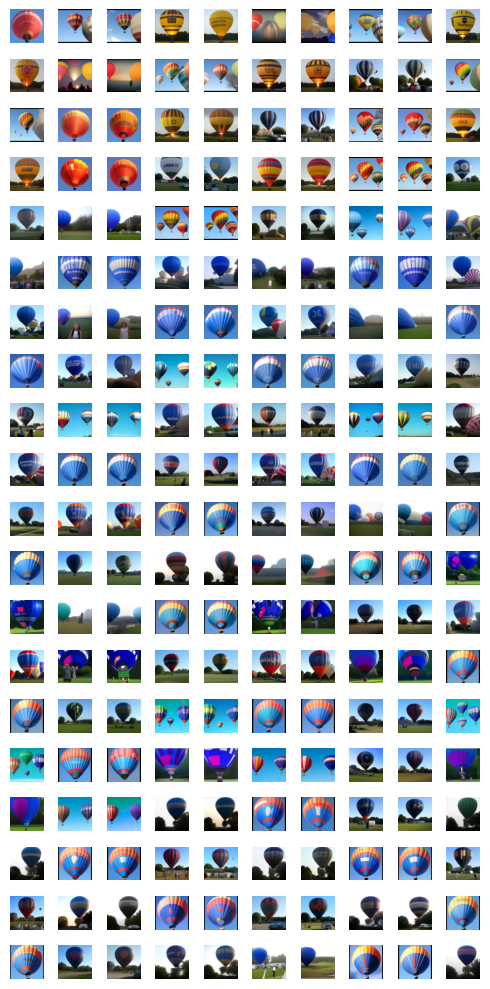

In [ ]:

images = data['final']  
images = images.squeeze(0)  

n_images = images.shape[0]
n_cols = 10
n_rows = (n_images + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols / 2, n_rows / 2)) ##  you can also change this line to make the image bigger
for i in range(n_images):
    img = images[i].detach().cpu()
    img = img.permute(1, 2, 0)  
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)  # normalize to [0,1]
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()


### Evaluate 

In [18]:
torch.manual_seed(20)
device = torch.device('cuda:0')

reward_model = RM.load("ImageReward-v1.0").to(device)
reward_model.eval()
print(f"Reward model device: {next(reward_model.parameters()).device}")

clip_model_name = "ViT-L/14@336px"  # match CLIPScore paper default
clip_model, clip_preprocess = clip.load(clip_model_name, device=device)
clip_model.eval()


@torch.inference_mode()
def compute_clip_and_imagereward(
    images: torch.Tensor,
    prompts: list[str],
    device,
    batch: int = 64,
    want_clip: bool = True,
    want_imr: bool = True,
):
    """
    images: [B, PT, C, H, W] uint8 (CUDA)
    returns (clip_scores[B,PT] or None, imr_scores[B,PT] or None) on CPU
    """
    assert images.is_cuda and images.dtype == torch.uint8
    B, PT, C, H, W = images.shape
    assert len(prompts) == B
    N = B * PT

    # Text features once
    if want_clip:
        tokens = clip.tokenize(prompts, context_length=77, truncate=True).to(device)
        txt = clip_model.encode_text(tokens)
        txt = txt / txt.norm(dim=-1, keepdim=True)
        txt_flat = txt.repeat_interleave(PT, dim=0)  # [N, D]

        # robust dtype for CLIP visual (works for ViT / RN)
        clip_dtype = next(clip_model.visual.parameters()).dtype
        clip_buf = torch.empty(N, dtype=torch.float32)  # CPU buffer

    imr_buf = torch.empty(N, dtype=torch.float32) if want_imr else None

    flat = images.reshape(N, C, H, W)

    for i in range(0, N, batch):
        j = min(i + batch, N)

        # one D2H copy + PIL construction
        np_hwc = flat[i:j].permute(0, 2, 3, 1).contiguous().cpu().numpy()
        pils = [PIL.Image.fromarray(arr) for arr in np_hwc]

        if want_clip:
            x = torch.stack([clip_preprocess(p) for p in pils]).to(device)
            x = x.to(dtype=clip_dtype)
            img = clip_model.encode_image(x)
            img = img / img.norm(dim=-1, keepdim=True)
            clip_buf[i:j] = (100.0 * (img * txt_flat[i:j]).sum(dim=-1)).detach().cpu()

        if want_imr:
            # ImageReward exposes .score(prompt, PIL.Image)
            for k, pil in enumerate(pils):
                b, _t = divmod(i + k, PT)
                imr_buf[i + k] = float(reward_model.score(prompts[b], pil))

    clip_scores = clip_buf.view(B, PT) if want_clip else None
    imr_scores  = imr_buf.view(B, PT)  if want_imr  else None
    return clip_scores, imr_scores



Couldn't access the Hub to check for update but local file already exists. Defaulting to existing file. (error: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /THUDM/ImageReward/resolve/main/ImageReward.pt (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1a286f7e00>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 355502f0-7b33-4825-a852-98c6e0ea8d3d)'))


load checkpoint from /root/.cache/ImageReward/ImageReward.pt


Couldn't access the Hub to check for update but local file already exists. Defaulting to existing file. (error: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /THUDM/ImageReward/resolve/main/med_config.json (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f1a286e4560>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 514380ac-6135-43a0-9fb1-0d1c79c11198)'))


checkpoint loaded
Reward model device: cuda:0


In [22]:
prompts_batch = {
    417: ['A blue balloon'],
    723: ['a colorful pinwheel'],
    496: ['a green Christmas stocking'],
    468: ['a yellow cab with dark background'],
    791: ['an empty shopping cart']
    }[class_idxs]
print(f"Prompts for current batch:\n{prompts_batch}")

Prompts for current batch:
['A blue balloon']


In [24]:
clip_scores, imr_scores = compute_clip_and_imagereward(data['final'].to(device), prompts_batch, device, batch=4)

In [25]:
# save the clip_scores and imr_scores
torch.save({'clip_scores': clip_scores, 'imr_scores': imr_scores}, f'results/class_{class_idxs}_{prompts_batch[0]}.pt')

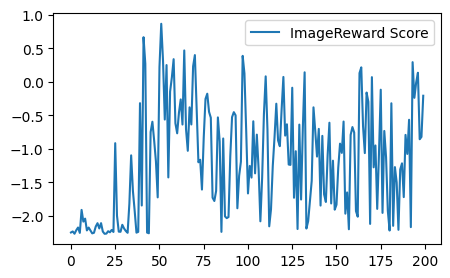

In [26]:
plt.figure(figsize=(5, 3))
plt.plot(imr_scores.mean(dim=0), label='ImageReward Score')
plt.legend()
plt.show()

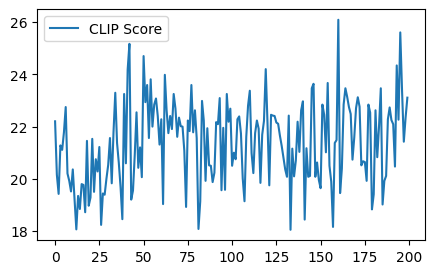

In [27]:
plt.figure(figsize=(5, 3))
plt.plot(clip_scores.mean(dim=0), label='CLIP Score')
plt.legend()
plt.show()